# Multivariate Time Series Analysis Notebook

## 1.1 Install the Necessary Packages

In [10]:
!pip install ibm_db

#### Restart the Kernel `Kernel>Restart`

## 1.2 Import the Packages

In [28]:
from sklearn import preprocessing
from matplotlib import pyplot as plt
import numpy as np

import ibm_db

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

## 2. Configuration

### 2.1 Insert the Db Credentials

Change the name to `credentials_1`

### 2.2 Insert the Dataset

Click on the `10/01` icon and then click on `Insert Pandas Dataframe`. Ensure the name is `df_data_1`

,outgoing_site_id,Start_Time_MM_DD_YYYY,Start_Time_HH_MM_SS_s,Weather,Total Calls,Traffic,lat,long,Call Dropped
0,1717,20170101,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16
1,1717,20170101,4:00 to 8:00,Shallow Fog,554,Medium,40.710567,-74.007338,44
2,1717,20170101,8:00 to 12:00,Shallow Fog,301,Low,40.710567,-74.007338,17
3,1717,20170101,12:00 to 16:00,Fog,514,Low,40.710567,-74.007338,16
4,1717,20170101,16:00 to 20:00,Fog,262,Low,40.710567,-74.007338,14


### 2.3 Global Variable

In [34]:
table_name="OUTPUT"

## 3. Pre-Processing

### 3.1 Prepare dataset for Time-Series Model

In [35]:
# Make column datatype a datetime object
df_data_1['Start_Time_MM_DD_YYYY'] = pd.to_datetime(df_data_1.Start_Time_MM_DD_YYYY , format = '%Y%m%d')




In [36]:
df_data_1

,outgoing_site_id,Start_Time_MM_DD_YYYY,Start_Time_HH_MM_SS_s,Weather,Total Calls,Traffic,lat,long,Call Dropped
0,1717,2017-01-01,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16
1,1717,2017-01-01,4:00 to 8:00,Shallow Fog,554,Medium,40.710567,-74.007338,44
2,1717,2017-01-01,8:00 to 12:00,Shallow Fog,301,Low,40.710567,-74.007338,17
3,1717,2017-01-01,12:00 to 16:00,Fog,514,Low,40.710567,-74.007338,16
4,1717,2017-01-01,16:00 to 20:00,Fog,262,Low,40.710567,-74.007338,14
5,1717,2017-01-01,20:00 to 23:59,Fog,587,Low,40.710567,-74.007338,15
6,1717,2017-01-02,00:00 to 4:00,Partly Cloudy,576,High,40.710567,-74.007338,57
7,1717,2017-01-02,4:00 to 8:00,Shallow Fog,544,Low,40.710567,-74.007338,16
8,1717,2017-01-02,8:00 to 12:00,Fog,247,Medium,40.710567,-74.007338,46
9,1717,2017-01-02,12:00 to 16:00,Fog,378,Medium,40.710567,-74.007338,37


In [37]:
# Set the date column as index for dataset
data = df_data_1.drop(['Start_Time_MM_DD_YYYY'], axis=1)
data.index = df_data_1.Start_Time_MM_DD_YYYY

In [38]:
''' NOTE: This example is given so that, ensure there are no nan's in your dataset 
    and they are replaced with type consistent missing values

data[' _dewptm']=data[' _dewptm'].fillna(1000)
'''

" NOTE: This example is given so that, ensure there are no nan's in your dataset \n    and they are replaced with type consistent missing values\n\ndata[' _dewptm']=data[' _dewptm'].fillna(1000)\n"

## 4. Time-Series Model Training

### 4.1 Train your AR Model

In [39]:
ts_data=data['Call Dropped']
ts_data

Start_Time_MM_DD_YYYY
2017-01-01    16
2017-01-01    44
2017-01-01    17
2017-01-01    16
2017-01-01    14
2017-01-01    15
2017-01-02    57
2017-01-02    16
2017-01-02    46
2017-01-02    37
2017-01-02    17
2017-01-02    15
2017-01-03    50
2017-01-03    43
2017-01-03    60
2017-01-03    44
2017-01-03    60
2017-01-03    63
2017-01-04    38
2017-01-04    51
2017-01-04    64
2017-01-04    34
2017-01-05    43
2017-01-06    39
2017-01-06    59
2017-01-07    32
2017-01-07    31
2017-01-07    29
2017-01-07    22
2017-01-07    27
              ..
2017-01-26    48
2017-01-26    15
2017-01-27    34
2017-01-27    51
2017-01-27    32
2017-01-27    35
2017-01-27    50
2017-01-27    16
2017-01-28    40
2017-01-28    23
2017-01-28    29
2017-01-28    57
2017-01-28    43
2017-01-28    13
2017-01-29    20
2017-01-29    37
2017-01-29    44
2017-01-29    50
2017-01-29    49
2017-01-29    37
2017-01-30    39
2017-01-30    57
2017-01-30    35
2017-01-30    26
2017-01-30    48
2017-01-30    43
2017-01-3

In [40]:
ts_log = np.log(ts_data)

In [41]:
ts_log_diff = ts_log - ts_log.shift()

In [42]:
ts_log_diff.dropna(inplace=True)
ts_log_diff

Start_Time_MM_DD_YYYY
2017-01-01    1.011601
2017-01-01   -0.950976
2017-01-01   -0.060625
2017-01-01   -0.133531
2017-01-01    0.068993
2017-01-02    1.335001
2017-01-02   -1.270463
2017-01-02    1.056053
2017-01-02   -0.217723
2017-01-02   -0.777705
2017-01-02   -0.125163
2017-01-03    1.203973
2017-01-03   -0.150823
2017-01-03    0.333144
2017-01-03   -0.310155
2017-01-03    0.310155
2017-01-03    0.048790
2017-01-04   -0.505549
2017-01-04    0.294239
2017-01-04    0.227057
2017-01-04   -0.632523
2017-01-05    0.234840
2017-01-06   -0.097638
2017-01-06    0.413976
2017-01-07   -0.611802
2017-01-07   -0.031749
2017-01-07   -0.066691
2017-01-07   -0.276253
2017-01-07    0.204794
2017-01-07   -0.351398
                ...   
2017-01-26    0.000000
2017-01-26   -1.163151
2017-01-27    0.818310
2017-01-27    0.405465
2017-01-27   -0.466090
2017-01-27    0.089612
2017-01-27    0.356675
2017-01-27   -1.139434
2017-01-28    0.916291
2017-01-28   -0.553385
2017-01-28    0.231802
2017-01-28  

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 1694.6424')

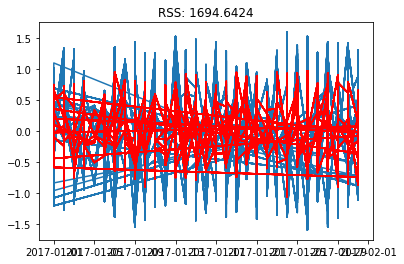

In [43]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

In [44]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Start_Time_MM_DD_YYYY
2017-01-01    0.000128
2017-01-01   -0.490873
2017-01-01    0.256458
2017-01-01    0.395915
2017-01-01    0.111940
dtype: float64


In [45]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Start_Time_MM_DD_YYYY
2017-01-01    0.000128
2017-01-01   -0.490746
2017-01-01   -0.234288
2017-01-01    0.161627
2017-01-01    0.273567
dtype: float64

In [46]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


Start_Time_MM_DD_YYYY
2017-01-01    2.772717
2017-01-01    2.281843
2017-01-01    2.538301
2017-01-01    2.934216
2017-01-01    3.046156
dtype: float64

In [47]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

In [48]:
predictions_ARIMA=predictions_ARIMA.groupby('Start_Time_MM_DD_YYYY').head(6)

### 4.3 Prepare the Dataset for Dashboard

In [49]:
data=data.groupby('outgoing_site_id').head(6)
data

,outgoing_site_id,Start_Time_HH_MM_SS_s,Weather,Total Calls,Traffic,lat,long,Call Dropped
Start_Time_MM_DD_YYYY,,,,,,,,
2017-01-01,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16
2017-01-01,1717,4:00 to 8:00,Shallow Fog,554,Medium,40.710567,-74.007338,44
2017-01-01,1717,8:00 to 12:00,Shallow Fog,301,Low,40.710567,-74.007338,17
2017-01-01,1717,12:00 to 16:00,Fog,514,Low,40.710567,-74.007338,16
2017-01-01,1717,16:00 to 20:00,Fog,262,Low,40.710567,-74.007338,14
2017-01-01,1717,20:00 to 23:59,Fog,587,Low,40.710567,-74.007338,15
2017-01-01,3066,00:00 to 4:00,Smoke,419,Low,40.712100,-74.005152,18
2017-01-01,3066,4:00 to 8:00,Shallow Fog,644,Medium,40.712100,-74.005152,28
2017-01-01,3066,8:00 to 12:00,Shallow Fog,597,Medium,40.712100,-74.005152,43


In [50]:
merged_data=pd.merge(data,pd.DataFrame({"Call Drop Predictions":predictions_ARIMA.astype(int)}), how='inner', left_index=True, right_index=True)
merged_data

,outgoing_site_id,Start_Time_HH_MM_SS_s,Weather,Total Calls,Traffic,lat,long,Call Dropped,Call Drop Predictions
Start_Time_MM_DD_YYYY,,,,,,,,,
2017-01-01,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16,16
2017-01-01,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16,9
2017-01-01,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16,12
2017-01-01,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16,18
2017-01-01,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16,21
2017-01-01,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16,7
2017-01-01,1717,4:00 to 8:00,Shallow Fog,554,Medium,40.710567,-74.007338,44,16
2017-01-01,1717,4:00 to 8:00,Shallow Fog,554,Medium,40.710567,-74.007338,44,9
2017-01-01,1717,4:00 to 8:00,Shallow Fog,554,Medium,40.710567,-74.007338,44,12


In [51]:
merged_data['Predicted_Call_Drop_Perc']=round((merged_data['Call Drop Predictions']/merged_data['Total Calls'])*100,2)
merged_data

,outgoing_site_id,Start_Time_HH_MM_SS_s,Weather,Total Calls,Traffic,lat,long,Call Dropped,Call Drop Predictions,Predicted_Call_Drop_Perc
Start_Time_MM_DD_YYYY,,,,,,,,,,
2017-01-01,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16,16,3.21
2017-01-01,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16,9,1.80
2017-01-01,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16,12,2.40
2017-01-01,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16,18,3.61
2017-01-01,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16,21,4.21
2017-01-01,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16,7,1.40
2017-01-01,1717,4:00 to 8:00,Shallow Fog,554,Medium,40.710567,-74.007338,44,16,2.89
2017-01-01,1717,4:00 to 8:00,Shallow Fog,554,Medium,40.710567,-74.007338,44,9,1.62
2017-01-01,1717,4:00 to 8:00,Shallow Fog,554,Medium,40.710567,-74.007338,44,12,2.17


In [52]:
merged_data=merged_data.groupby(['outgoing_site_id','Start_Time_HH_MM_SS_s']).head(1)
merged_data

,outgoing_site_id,Start_Time_HH_MM_SS_s,Weather,Total Calls,Traffic,lat,long,Call Dropped,Call Drop Predictions,Predicted_Call_Drop_Perc
Start_Time_MM_DD_YYYY,,,,,,,,,,
2017-01-01,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16,16,3.21
2017-01-01,1717,4:00 to 8:00,Shallow Fog,554,Medium,40.710567,-74.007338,44,16,2.89
2017-01-01,1717,8:00 to 12:00,Shallow Fog,301,Low,40.710567,-74.007338,17,16,5.32
2017-01-01,1717,12:00 to 16:00,Fog,514,Low,40.710567,-74.007338,16,16,3.11
2017-01-01,1717,16:00 to 20:00,Fog,262,Low,40.710567,-74.007338,14,16,6.11
2017-01-01,1717,20:00 to 23:59,Fog,587,Low,40.710567,-74.007338,15,16,2.73
2017-01-01,3066,00:00 to 4:00,Smoke,419,Low,40.712100,-74.005152,18,16,3.82
2017-01-01,3066,4:00 to 8:00,Shallow Fog,644,Medium,40.712100,-74.005152,28,16,2.48
2017-01-01,3066,8:00 to 12:00,Shallow Fog,597,Medium,40.712100,-74.005152,43,16,2.68


In [53]:
merged_data=merged_data.reset_index()
del merged_data['Start_Time_MM_DD_YYYY']

In [54]:
merged_data = merged_data.replace(np.nan, 0, regex=True)

In [55]:
merged_data

,outgoing_site_id,Start_Time_HH_MM_SS_s,Weather,Total Calls,Traffic,lat,long,Call Dropped,Call Drop Predictions,Predicted_Call_Drop_Perc
0,1717,00:00 to 4:00,Smoke,499,Low,40.710567,-74.007338,16,16,3.21
1,1717,4:00 to 8:00,Shallow Fog,554,Medium,40.710567,-74.007338,44,16,2.89
2,1717,8:00 to 12:00,Shallow Fog,301,Low,40.710567,-74.007338,17,16,5.32
3,1717,12:00 to 16:00,Fog,514,Low,40.710567,-74.007338,16,16,3.11
4,1717,16:00 to 20:00,Fog,262,Low,40.710567,-74.007338,14,16,6.11
5,1717,20:00 to 23:59,Fog,587,Low,40.710567,-74.007338,15,16,2.73
6,3066,00:00 to 4:00,Smoke,419,Low,40.712100,-74.005152,18,16,3.82
7,3066,4:00 to 8:00,Shallow Fog,644,Medium,40.712100,-74.005152,28,16,2.48
8,3066,8:00 to 12:00,Shallow Fog,597,Medium,40.712100,-74.005152,43,16,2.68
9,3066,12:00 to 16:00,Fog,403,Medium,40.712100,-74.005152,35,16,3.97


## 4.4 Store Data back to the Db

In [56]:
dsn_driver = "IBM DB2 ODBC DRIVER"
dsn_database = credentials_1['database'] 
dsn_hostname = credentials_1['host']
dsn_port = 50000               
dsn_uid = credentials_1['username']      
dsn_pwd = credentials_1['password']

dsn = (
    "DRIVER={{IBM DB2 ODBC DRIVER}};"
    "DATABASE="+str(dsn_database)+";"
    "HOSTNAME="+str(dsn_hostname)+";"
    "PORT="+str(dsn_port)+";"
    "PROTOCOL=TCPIP;"
    "UID="+str(dsn_uid)+";"
    "PWD="+str(dsn_pwd)+";").format(dsn_database, dsn_hostname, dsn_port, dsn_uid, dsn_pwd)



conn = ibm_db.connect(dsn, "", "")

### Note: Replace <Schema_Name> with an existing Schema name in your db

In [57]:
# Replace the Schema Name with the actual name
create_statement=pd.io.sql.get_schema(merged_data.reset_index(), table_name)
create_statement=create_statement.replace('TEXT', 'VARCHAR(500)')
create_statement=create_statement.replace('TIMESTAMP', 'VARCHAR(500)')
#create_statement= create_statement + "IN "+dsn_database
print(create_statement)
ibm_db.exec_immediate(conn, create_statement)

CREATE TABLE "OUTPUT" (
"index" INTEGER,
  "outgoing_site_id" INTEGER,
  "Start_Time_HH_MM_SS_s" VARCHAR(500),
  "Weather" VARCHAR(500),
  "Total Calls" INTEGER,
  "Traffic" VARCHAR(500),
  "lat" REAL,
  "long" REAL,
  "Call Dropped" INTEGER,
  "Call Drop Predictions" INTEGER,
  "Predicted_Call_Drop_Perc" REAL
)


/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  from ipykernel import kernelapp as app


In [59]:
tuple_of_tuples = tuple([tuple(x) for x in merged_data.values])
i=1
for x in merged_data.values:
    vals= (i,) + tuple(x)
    print(vals)
    sql = "INSERT INTO "+table_name+" VALUES"+ str(vals)
    i=i+1
    ins_sql=ibm_db.prepare(conn, sql)
    ibm_db.execute(ins_sql)

(1, 1717, '00:00 to 4:00', 'Smoke', 499, 'Low', 40.710567, -74.007338, 16, 16, 3.21)
(2, 1717, '4:00 to 8:00', 'Shallow Fog', 554, 'Medium', 40.710567, -74.007338, 44, 16, 2.89)
(3, 1717, '8:00 to 12:00', 'Shallow Fog', 301, 'Low', 40.710567, -74.007338, 17, 16, 5.32)
(4, 1717, '12:00 to 16:00', 'Fog', 514, 'Low', 40.710567, -74.007338, 16, 16, 3.11)
(5, 1717, '16:00 to 20:00', 'Fog', 262, 'Low', 40.710567, -74.007338, 14, 16, 6.11)
(6, 1717, '20:00 to 23:59', 'Fog', 587, 'Low', 40.710567, -74.007338, 15, 16, 2.73)
(7, 3066, '00:00 to 4:00', 'Smoke', 419, 'Low', 40.7121, -74.00515209999999, 18, 16, 3.82)
(8, 3066, '4:00 to 8:00', 'Shallow Fog', 644, 'Medium', 40.7121, -74.00515209999999, 28, 16, 2.48)
(9, 3066, '8:00 to 12:00', 'Shallow Fog', 597, 'Medium', 40.7121, -74.00515209999999, 43, 16, 2.68)
(10, 3066, '12:00 to 16:00', 'Fog', 403, 'Medium', 40.7121, -74.00515209999999, 35, 16, 3.97)
(11, 3066, '16:00 to 20:00', 'Fog', 526, 'Low', 40.7121, -74.00515209999999, 25, 16, 3.04)
(12,